## Performance evaluation

In [1]:
import dill
import math as ma
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd

from numpy.fft import fftshift, fft2, ifft2
from scipy.optimize import minimize
from numpy.random import randn

from utils import gaussian_profile, d_statistic_nll_linearized

In [2]:
seed = 12345
alpha_r = 2
alpha_n = 3
cxx_r = 4.0
cxx_n = 4.0
cyy_r = 4.0
cyy_n = 4.0
cth_r = 1.5708
cth_n = 0.0
sig_r = 0.0025
sig_n = 0.0025
half_Delta = [1, 0]
n = 64

## Synthesize some inputs

In [3]:
amb = alpha_r - alpha_n
apb_Delta = (alpha_r + alpha_n)*np.linalg.norm(half_Delta)*2
theta = ma.atan2(half_Delta[1], half_Delta[0])

In [4]:
print(amb, apb_Delta, theta)

-1 10.0 0.0


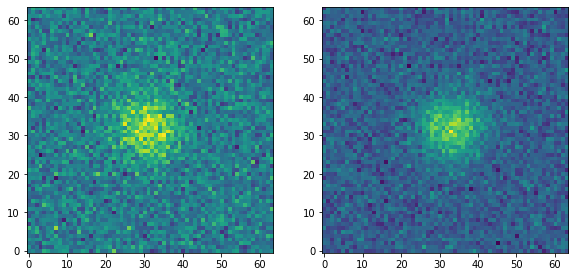

In [5]:
np.random.seed(seed)

q = np.array([n/2, n/2])
x0_r, y0_r = (q - half_Delta)
x0_n, y0_n = (q + half_Delta)

P_r = fftshift(gaussian_profile(n/2, n/2, [n, n], cxx_r, cyy_r, cth_r))
P_n = fftshift(gaussian_profile(n/2, n/2, [n, n], cxx_n, cyy_n, cth_n))
T_P_r = alpha_r * gaussian_profile(x0_r, y0_r, [n, n], cxx_r, cyy_r, cth_r)
T_P_n = alpha_n * gaussian_profile(x0_n, y0_n, [n, n], cxx_n, cyy_n, cth_n)

R = T_P_r + np.random.randn(n, n)*sig_r
N = T_P_n + np.random.randn(n, n)*sig_n

R_hat, N_hat, P_r_hat, P_n_hat = map(np.fft.fft2,[R, N, P_r, P_n])

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(R, origin='lower')
plt.subplot(1,3,2); plt.imshow(N, origin='lower')

## Visualizing the error surface (sans $\theta$)

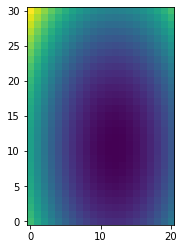

In [6]:
amb_ = np.linspace(-3, 3, 31)
apb_Delta_ = np.linspace(-60, 60, 21)
nll = np.zeros((amb_.shape[0], apb_Delta_.shape[0]))
for i, amb__ in enumerate(amb_):
    for j, apb_Delta__ in enumerate(apb_Delta_):
        nll[i,j] = d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, amb__, apb_Delta__, theta)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow((nll-np.min(nll)), origin='lower')

## Find maximum-likelihood using Nelder-Mead

In [7]:
x0 = [0.0, 0.0, 0.0]
nll = lambda x : d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, x[0], x[1], x[2])
min_ = minimize(nll, x0, method='Nelder-Mead', options={'disp': False, 'ftol': 1e-15})

nll_hess = nd.Hessian(nll, step=0.1)
nll_hess_eval = nll_hess(min_.x)
nll_cov = np.linalg.inv(nll_hess_eval)
w, v = np.linalg.eig(nll_cov[:3, :3])

truth = np.array([amb, apb_Delta, theta])
estim = min_.x
sigmas = w**0.5
errors = estim - truth

np.set_printoptions(precision=3, floatmode='fixed', sign='+')

print('truth             ', truth)
print('estimate          ', estim)
print('sigmas            ', sigmas)
print('errors            ', errors)
print('errors in sigmas  ', errors / sigmas)

truth              [ -1.000 +10.000  +0.000]
estimate           [ -0.894 +11.476  -0.071]
sigmas             [+0.071 +1.155 +0.101]
errors             [+0.106 +1.476 -0.071]
errors in sigmas   [+1.480 +1.278 -0.707]


## Perform MCMC sampling

In [8]:
import emcee
import multiprocessing
import corner

ndim, nwalkers = 3, 100
num_threads = int(multiprocessing.cpu_count() / 2)

def lnprob(theta, R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q):    
    return -d_statistic_nll_linearized(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q, 
                                       theta[0], theta[1], theta[2])

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=num_threads, 
                                args=(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, q))

pos = [estim + 0.5*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 750);
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

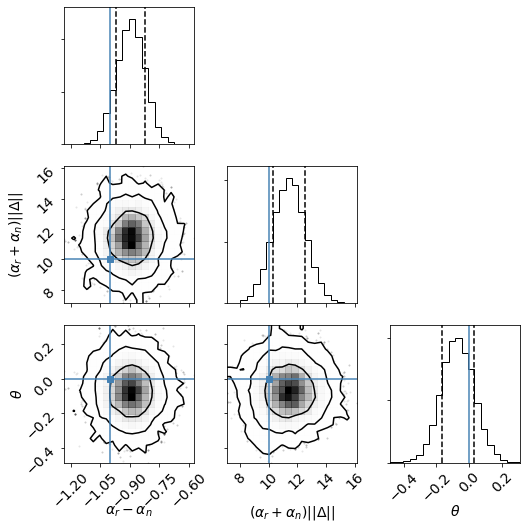

In [12]:
from matplotlib import rcParams
rcParams["font.size"] = 14

corner.corner(samples, 
              labels=["$\\alpha_r-\\alpha_n$", "$(\\alpha_r+\\alpha_n)||\\Delta||$", "$\\theta$"], 
              truths=truth, 
              quantiles=(0.16, 0.84),
              levels=(0.68, 0.95, 0.997), label_kwargs={"fontsize": 14});
plt.tight_layout()

plt.savefig("figures/discrim_linear.pdf")

In [10]:
"""
R = np.random.randn(n, n)*sig_r
N = np.random.randn(n, n)*sig_n

R_hat = np.fft.fft2(R)
N_hat = np.fft.fft2(N)

plt.imshow(np.real(N_hat))

print(np.mean(2*np.real(N_hat)**2)**0.5)
print(sig_n*n)
"""
pass

In [11]:
dill.dump_session('output/discrim_linear.pkl')